# Testing saddle point problems in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

First create a grid and a Laplacian operator on it

In [3]:
nx = 130; ny = 130;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [4]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 130, ny = 130) grid with spacing 1.0

Now create a shape, with discrete points and associated regularization and interpolation operator

In [12]:
n = 128;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ)
yb = 1.0 + R*sin.(θ)
ds = (2π/n)*R;
X = VectorData(xb[1:n],yb[1:n]);
f = ScalarData(X);

In [7]:
E = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true)
#Ẽ = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true,filter=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

In [6]:
Ẽ = Regularize(X,dx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(Ẽ,f,w);
Ẽmat = InterpolationMatrix(Ẽ,w,f);

In [8]:
PS = SaddleSystem((w,f),(x->L\x,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with
   State of type Whirl.SaddlePointSystems.##4#10
   Force of type Whirl.Fields.Nodes{Whirl.Fields.Dual,130,130}


In [9]:
P(f) = Ẽmat*(H̃mat*f)
PScond = SaddleSystem((w,f),(x->L\x,Hmat,Emat),issymmetric=true,isposdef=true,conditioner=P)

Saddle system with
   State of type #P
   Force of type Whirl.Fields.Nodes{Whirl.Fields.Dual,130,130}


  0.027279 seconds (122 allocations: 1.337 MiB)


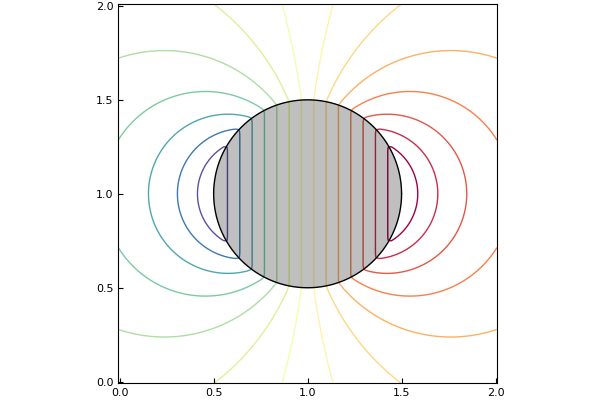

In [20]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n]-1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = PS\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [9]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f./ds-fex,Inf)

0.03528802363993222

  0.027793 seconds (139 allocations: 1.521 MiB)


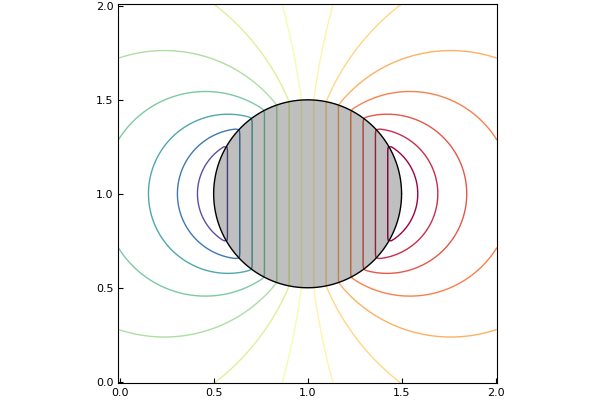

In [21]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n]-1);
f̃ = ScalarData(X);
ψ = Nodes(Dual,w);
@time ψ,f̃ = PScond\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [22]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f̃./ds-fex,Inf)

0.03498702522067454

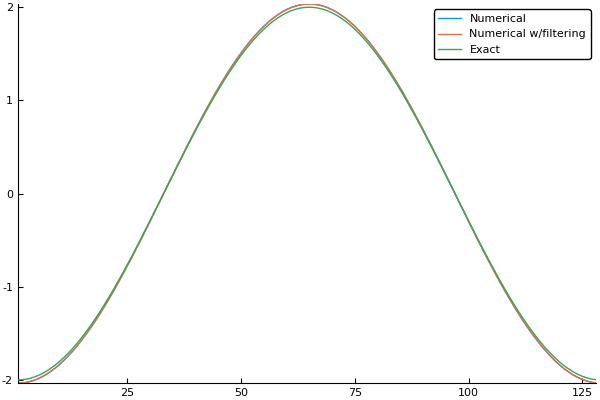

In [23]:
plot(f./ds,label="Numerical")
plot!(f̃./ds,label="Numerical w/filtering")
plot!(fex,label="Exact")

Test with the integrating factor as the operator, rather than Laplacian

In [11]:
Δt = 1.0
HS = SaddleSystem((w,f),(plan_intfact(Δt,w),Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,130,130}
   Force of type Whirl.Fields.ScalarData{128}


In [12]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb-1).*(yb-1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = HS\(w,ψb)

  0.055126 seconds (278 allocations: 3.223 MiB)


(Whirl.Fields.Dual nodes in a (nx = 130, ny = 130) cell grid
  Number of Whirl.Fields.Dual nodes: (nx = 130, ny = 130), 128 points of scalar-valued data
)

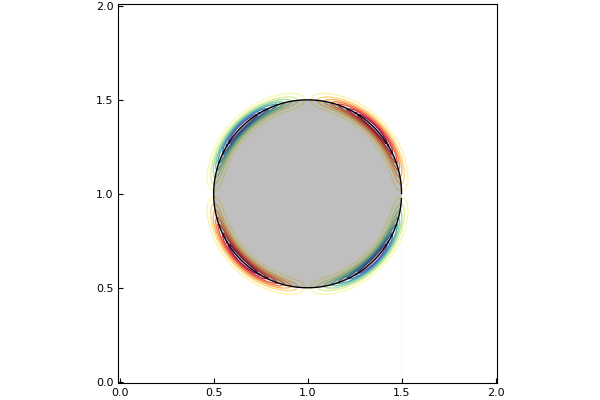

In [13]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)